In [1]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_index >= 0 else np

# 車輪型ロボットモデル（対向2輪型）

In [3]:
class CartLayer:
    def __init__(self,batchsize=1):
        self.cart_num = batchsize
        self.pos = Variable(np.zeros( (batchsize,3), dtype=np.float32))
        self.path = np.zeros( (1,batchsize,3),dtype=float)

    def move(self,param):
        if len(param) == self.cart_num:
            dx = F.reshape(param[:,0] * F.cos(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dy = F.reshape(param[:,0] * F.sin(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dth = F.reshape(param[:,1], (self.cart_num,1))
            D = F.concat((dx,dy),axis=1)
            D = F.concat((D,dth),axis=1)
            self.pos = self.pos + D
            self.path = np.vstack([self.path,[self.pos.data]])
            return self.pos
        else:
            print 'len(param) != cart_num'
            return -1

# 連続で動く
def calc_car_pos(cart_layer, y):
    for step in range(len(y[0])):
        cart_layer.move(y[:,step])
    # print car.path.shape  # (4step, 50batch, 3x-y-th)
    # print car.pos.data.shape  # (50batch, 3x-y-th)
    return cart_layer.pos

# 経路の描画

In [4]:
def plot_path(cart_path,target):
    path = cart_path[:,0,:]
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   ,scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[0],target[1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.axis('scaled')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.show()

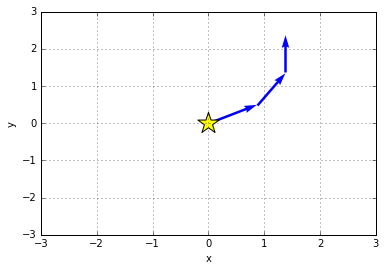

[[[0.         0.         0.        ]]

 [[0.86602539 0.5        0.52359879]]

 [[1.36602533 1.36602545 1.04719758]]

 [[1.36602533 2.36602545 1.57079637]]]


''

In [5]:
''' sample '''
v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
w_arr = np.array([30.0,30.0,30.0],dtype=np.float32)
w_arr = w_arr * np.pi/180
y_data = np.vstack((v_arr,w_arr)).T
yV = Variable(np.reshape(y_data,(1,3,2) )) 

sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,yV)
plot_path(sample_cart.path,[0,0])
print sample_cart.path
''''''

# ネットワーク

In [6]:
class Generator(Chain):
    def __init__(self):
        initializer = initializers.HeNormal()
        super(Generator, self).__init__(
            l1=L.Linear(2, 15, initialW=initializer),
            l2=L.Linear(15, 8, initialW=initializer),
            l3=L.Linear(8, 6, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        h4 = F.tanh(h3)
        o = F.reshape(h4,(len(x),3,2))
        return o
    '''
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

**入出力を確認**

In [7]:
''' sample '''
sample_model = Generator()
sample_x_data = np.array([[3,0]],dtype=np.float32)
sample_x = Variable(sample_x_data)
print sample_x_data
sample_y = sample_model(sample_x_data)
print sample_y
''' '''

[[3. 0.]]
variable([[[-0.9867225  -0.84820765]
           [ 0.7227415  -0.9984141 ]
           [ 0.7267933   0.00864794]]])


' '

### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**

# 極座標変換

[1, 1]
[1.4142135623730951, 45.0]


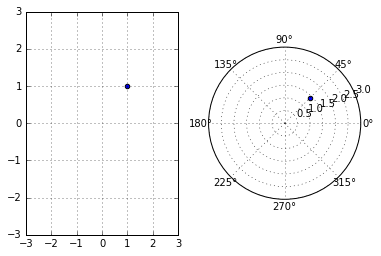

In [8]:
# 極座標変換
def to_polar_coordinate(x,y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return r,theta
# 直交座標変換
def to_cartesian_coordinate(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

sample_x,sample_y = [1,1]
sample_r,sample_theta = to_polar_coordinate(sample_x,sample_y)
print [sample_x,sample_y]
print [sample_r, sample_theta*180/np.pi]
# 直交系グラフ
ax1 = plt.subplot(1,2,1)
ax1.scatter(sample_x,sample_y)
ax1.axis([-3,3,-3,3])
ax1.grid(True)

# 極座標系グラフ
ax2 = plt.subplot(1,2,2,polar=True)
ax2.scatter(sample_theta,sample_r)
ax2.set_rmax(3)
ax2.grid(True)


# 訓練データの作成

* 極座標系で角度をランダムに指定  

\begin{equation*}
\begin{bmatrix}
r = 2 \\
-\frac{π}{2} < θ < \frac{π}{2}
\end{bmatrix}
\end{equation*}

DATA_SHAPE(1000, 2)


array([[ 0.3087263 ,  1.9760283 ],
       [ 1.7075903 ,  1.0412182 ],
       [ 1.4492782 ,  1.378257  ],
       ...,
       [ 0.42721894, -1.9538382 ],
       [ 1.9920504 ,  0.17814367],
       [ 1.9109824 , -0.5900393 ]], dtype=float32)

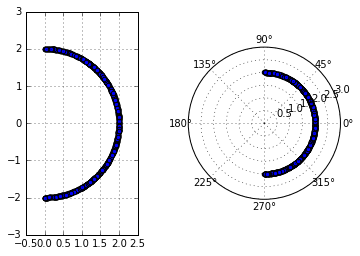

In [9]:
def random_point(size):
    r = np.full(size, 2)
    theta = np.random.rand(size) * np.pi - (np.pi/2)
    # theta = np.random.rand(size) * 2 * np.pi - (np.pi)
    return r, theta

def generate_dataset(r,theta,plot=0):
    x,y = to_cartesian_coordinate(r,theta)
    x_data = np.vstack([x,y])
    x_data = x_data.T
    x_data = np.array(x_data, dtype=np.float32)
    print 'DATA_SHAPE{}'.format(x_data.shape)
    if (plot>0) :
        fig1 = plt.subplot(1,2,2,polar=True)
        fig1.scatter(theta,r)
        fig1.set_rmax(3)
        fig1.grid(True)

        fig2 = plt.subplot(1,2,1)
        fig2.scatter(x,y)
        fig2.axis([-3,3,0,3])
        plt.axis('scaled')
        fig2.grid(True)
    return x_data
r, theta = random_point(1000)
generate_dataset(r,theta,plot=1)
# print x_data

# 損失関数

In [10]:
def calc_distance(predpos,truepos):
    px, py, _ = predpos
    tx, ty = truepos
    D = F.sqrt( (tx-px)**2 + (ty-py)**2 )
    # print "p:{},{} t:{},{}  = D:{}".format(px,py,tx,ty,D)
    return D

#sample_p = Variable(np.array([-0.04729605 , 3.132064, 0], dtype=np.float32))
#sample_t = Variable(np.array([-0.9656074  ,1.9671886], dtype=np.float32))
#print calc_distance(sample_p,sample_t)
# 1.4833174

def velo_diff(v):
    # v (batch,3)
    V = np.zeros(len(v),dtype=np.float32)
    for i in range(len(v[0])-1):
        diff = v[:,i] - v[:,i+1]
        # print '{} = {} - {}'.format(diff, v[:,i], v[:,i+1])
        V = V + diff*diff
    init_v = np.zeros(len(v),dtype=np.float32)
    diff = init_v - v[:,0]
    # print '{} = {} - {}'.format(diff, init_v, v[:,0])
    V = V + diff*diff
    return V
    
def loss_function(y, predpos, truepos):
    ppos = F.transpose(predpos) #(batch,3) -> (3,batch)
    tpos = F.transpose(truepos) #(2,batch)
    # print ppos
    # print tpos
    D = calc_distance(ppos, tpos)
    v = y[:,:,0]
    w = y[:,:,1]
    V = velo_diff(v)
    W = velo_diff(w)
    E = (1*D) + (1*V) + (1*W)
    # print 'D :{}'.format(D)
    # print 'V :{}, v:{}'.format(V,v)
    # print 'W :{}, w:{}'.format(W,w)
    loss = F.mean(E)
    return loss

'''
sample_y    = Variable(np.array([[[1,2], [1,2], [1,2]], [[3,4], [3,4], [3,4]]] ,dtype=np.float32 ))
sample_pred = Variable(np.array([[1,1,0], [1,1,0]] ,dtype=np.float32 ))
sample_true = Variable(np.array([[1,1], [1,1]] ,dtype=np.float32 ))

#sample_y    = Variable(np.array([[[2,2,2], [1,1,1]]] ,dtype=np.float32 ))
#sample_pred = Variable(np.array([[1,1,0]] ,dtype=np.float32 ))
#sample_true = Variable(np.array([[1,1]] ,dtype=np.float32 ))

print loss_function(sample_y, sample_pred, sample_true)
'''

'\nsample_y    = Variable(np.array([[[1,2], [1,2], [1,2]], [[3,4], [3,4], [3,4]]] ,dtype=np.float32 ))\nsample_pred = Variable(np.array([[1,1,0], [1,1,0]] ,dtype=np.float32 ))\nsample_true = Variable(np.array([[1,1], [1,1]] ,dtype=np.float32 ))\n\n#sample_y    = Variable(np.array([[[2,2,2], [1,1,1]]] ,dtype=np.float32 ))\n#sample_pred = Variable(np.array([[1,1,0]] ,dtype=np.float32 ))\n#sample_true = Variable(np.array([[1,1]] ,dtype=np.float32 ))\n\nprint loss_function(sample_y, sample_pred, sample_true)\n'

# 訓練

In [11]:
def train(x_data, max_epoch, batch_size, snapshot=10):
    model = Generator()
    opt = optimizers.Adam()
    gpu_id = -1
    if gpu_id >= 0:
        model.to_gpu(gpu_id)
    train_iter = iterators.SerialIterator(x_data, batch_size)
    opt.setup(model)
    epoch = 0
    while train_iter.epoch < max_epoch:
        train_batch = np.array(train_iter.next())
        x = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        y = model(x)
        truepos = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        car = CartLayer(len(y))
        predpos = calc_car_pos(car, y)
        loss = loss_function(y,predpos,truepos)
        model.cleargrads()
        loss.backward()
        opt.update(loss_function,y,predpos,truepos)
        epoch = epoch + 1
        if (epoch % snapshot)==0:
            print str(epoch)+": loss "+str(loss.data)
            # print model.l1.W.grad
            # plot_path(car.path, target_pos.data)
    return model

# parameter
batch_size = 10
max_epoch  = 100
snapshot = 20
# dataset
data_size  = 1000
r, theta = random_point(data_size)
x_data = generate_dataset(r,theta)
model = train(x_data, max_epoch, batch_size, snapshot)

DATA_SHAPE(1000, 2)
20: loss 5.011236
40: loss 4.301013
60: loss 3.7319615
80: loss 3.148956
100: loss 2.2507627
120: loss 2.067549
140: loss 1.8073689
160: loss 1.7962016
180: loss 1.430092
200: loss 1.7400696
220: loss 1.3789777
240: loss 0.9865264
260: loss 1.3208753
280: loss 1.0754968
300: loss 0.9471739
320: loss 1.0712245
340: loss 1.2395556
360: loss 1.0151043
380: loss 0.66424173
400: loss 0.87321484
420: loss 0.9766553
440: loss 0.9442439
460: loss 0.8712034
480: loss 0.87307674
500: loss 0.791226
520: loss 0.7607505
540: loss 0.6176579
560: loss 0.77083725
580: loss 0.78765124
600: loss 0.72895604
620: loss 0.63720745
640: loss 0.49308968
660: loss 0.5025663
680: loss 0.6300916
700: loss 0.5269926
720: loss 0.551542
740: loss 0.7227749
760: loss 0.69519395
780: loss 0.5372016
800: loss 0.5332892
820: loss 0.62048405
840: loss 0.5692751
860: loss 0.46173248
880: loss 0.53010863
900: loss 0.5730418
920: loss 0.5081902
940: loss 0.4744063
960: loss 0.5386631
980: loss 0.4504846

7680: loss 0.489801
7700: loss 0.43274155
7720: loss 0.41271725
7740: loss 0.41720435
7760: loss 0.47263226
7780: loss 0.38986143
7800: loss 0.43177062
7820: loss 0.48510757
7840: loss 0.44444156
7860: loss 0.50905436
7880: loss 0.46638155
7900: loss 0.45014873
7920: loss 0.45952207
7940: loss 0.43928152
7960: loss 0.43330765
7980: loss 0.39071333
8000: loss 0.43330774
8020: loss 0.47866097
8040: loss 0.51263446
8060: loss 0.53770393
8080: loss 0.49257484
8100: loss 0.41424832
8120: loss 0.45105052
8140: loss 0.5138745
8160: loss 0.3946745
8180: loss 0.45034215
8200: loss 0.41877022
8220: loss 0.585332
8240: loss 0.4401556
8260: loss 0.40855345
8280: loss 0.41989103
8300: loss 0.41191846
8320: loss 0.49810743
8340: loss 0.54607356
8360: loss 0.41411677
8380: loss 0.47054735
8400: loss 0.5312368
8420: loss 0.3804808
8440: loss 0.54235077
8460: loss 0.49587736
8480: loss 0.4641667
8500: loss 0.4574719
8520: loss 0.44767448
8540: loss 0.47238764
8560: loss 0.47077242
8580: loss 0.51984876

# 推論

DATA_SHAPE(1, 2)
loss: variable(0.5169265)bbbbb
v,w: 
variable([[[ 0.4348397  -0.3686374 ]
           [ 0.77139306 -0.52967757]
           [ 0.9652716  -0.549229  ]]])


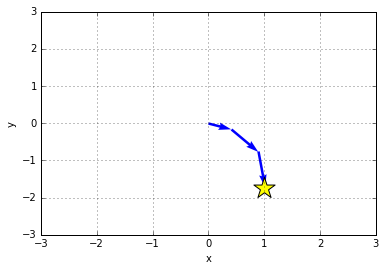

In [27]:
def predict(model, x_test, plot=0):
    x_data = Variable(x_test)
    o = model(x_data)
    car = CartLayer(len(o))
    predpos = calc_car_pos(car, o)
    truepos = Variable(x_test)
    loss = loss_function(o,predpos, truepos)
    print "loss: {}bbbbb".format(loss)
    print "v,w: \n{}".format(o)
    # print car.path
    if(plot>0):
        plot_path(car.path, x_data.data[0])

sample_r     = [2]
sample_theta = [np.deg2rad(-60)]
sample_x_test = generate_dataset(sample_r,sample_theta)
predict(model, sample_x_test, plot=1)

# 重みの保存と読み込み

In [13]:
# save
def save_pretrained(model, name):
    serializers.save_npz(name, model)

save_pretrained(model, 'tmp.model')

In [14]:
# rename model
import os
import datetime

name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
name_epoch = '{}epoch'.format(max_epoch)
name_batch = '{}batch'.format(batch_size)
name_datasize  = '{}data'.format(data_size)
model_name = name_datasize + name_batch + name_epoch + '_' + name_date + '.model' 
print model_name
# os.rename('tmp.model', model_name)

1000data10batch100epoch_20190201162128.model


In [15]:
# load
def load_pretrained(name):
    load_model = Generator()
    serializers.load_npz(name, load_model)
    return load_model

load_model = load_pretrained('tmp.model')

sample_r     = [2]
sample_theta = [np.deg2rad(0)]
sample_x_test = generate_dataset(sample_r,sample_theta)
predict(load_model, sample_x_test, plot=0)

DATA_SHAPE(1, 2)
loss: variable(0.2987355)bbbbb
v,w: 
variable([[[ 0.42097545 -0.01303103]
           [ 0.7187794  -0.00227076]
           [ 0.84534234  0.03157258]]])


### 2018/11/27
---
* バッチで処理 →　学習回数を増やしてデータを取る
* ネットワークを変える

### 2019/01/22 オフィスアワー 

* 次元ごとにforwordして結果を比較 
* lossを貯めて擬似的にmini-batch処理
* chainer SLAM 藤本さん qiita の記事?
* 同次変換行列ができれば...
* バッチ処理は先送りするのも検討
* 経路の途中の計算を諦めて評価値だけ天から降ってくるものとして扱う案
* NNで最適制御（普通の制御よりは複雑（非線形項））
* 前後左右の加減速（ドローンの風で安定しないなど）

### 次回までの課題
* 180度を跨がない
  - -90～90度の範囲で学習
  
* tanh (-1 ~ 1)やシグモイド(正)で無茶な加減速を抑制
  - tanh層を加えた
  - 最大速度　　:１
  - 最大角速度　:

* 学習回数を増やして結果を比較
  - 今まで1000データ 5エポック
  - 今回は1000データ 50エポック

* (できたらバッチ処理)
  - 次元ごとにforwordして結果を比較した
  - lossが怪しい

## 検証① 入力がバッチのとき・バッチでないときの結果を比較

In [16]:
sample_input = np.array([ [2,0], [0,2], [0,-2] ], dtype=np.float32)
predict(model, sample_input)
print '\n---\n'
predict(model,np.array([[2,0]], dtype=np.float32))
predict(model,np.array([[0,2]], dtype=np.float32))
predict(model,np.array([[0,-2]], dtype=np.float32))

loss: variable(0.6707916)bbbbb
v,w: 
variable([[[ 0.42097545 -0.01303098]
           [ 0.7187794  -0.00227075]
           [ 0.84534234  0.0315726 ]]

          [[ 0.46001548  0.57559735]
           [ 0.88841856  0.75026006]
           [ 0.99527067  0.77164686]]

          [[ 0.46643886 -0.5945964 ]
           [ 0.89487296 -0.76957893]
           [ 0.99603045 -0.76746666]]])

---

loss: variable(0.2987355)bbbbb
v,w: 
variable([[[ 0.42097545 -0.01303103]
           [ 0.7187794  -0.00227076]
           [ 0.84534234  0.03157258]]])
loss: variable(0.87348425)bbbbb
v,w: 
variable([[[0.4600156  0.57559735]
           [0.88841856 0.7502601 ]
           [0.99527067 0.77164686]]])
loss: variable(0.8401551)bbbbb
v,w: 
variable([[[ 0.46643886 -0.5945964 ]
           [ 0.8948729  -0.769579  ]
           [ 0.99603045 -0.76746666]]])


# 分散

In [17]:
sample_x = [1,2,3,4]
sample_y = [1,4,9,16]
sample_error = [1,4,9,16]
def plot_error(x,y,err):
    plt.plot(x,y)
    plt.errorbar(x,y,yerr=err,ecolor='r',color='b',ls='solid',lw=2,marker='o')
    plt.show()

# plot_error(sample_x,sample_y,sample_error)

### 2019/01/29 オフィスアワー

* 損失の計算確認
  - Reshapeが間違い
  - 速度・角速度計算の入力に間違い（参照axisがおかしかった）
* 途中経路の入力（損失の計算方法を考える